In [1]:
from scipy.signal import convolve2d
from scipy.optimize import minimize
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
plt.style.use(astropy_mpl_style)
import emcee
import corner
from IPython.display import display, Math
from fonctions import *

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_60597/496026857.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


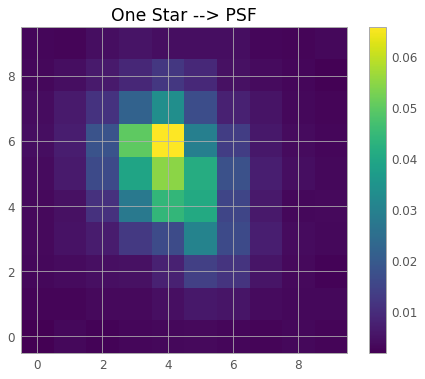

In [2]:
# Opening the images
img = fits.getdata('image2.fit')
bias = fits.getdata('bias.fit')
dark = fits.getdata('dark.fit')
flat = fits.getdata('flat.fit')

# Averaging the calibration frames
bias = averageFolder('bias')
dark = averageFolder('dark')
flat = averageFolder('flat')

# Image calibrated using the different calibration frames
image_clean = calibrate(img, bias, dark, flat)

# PSF of one star
#PSF = image_clean[2926-10:2926+10, 2029-10:2029+10]
PSF = image_clean[2628:2638, 822:832]
PSF = PSF / np.sum(PSF)  # normalized as a distribution to 1
plt.figure()
plt.title('One Star --> PSF')
plt.imshow(PSF, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_60597/253592785.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


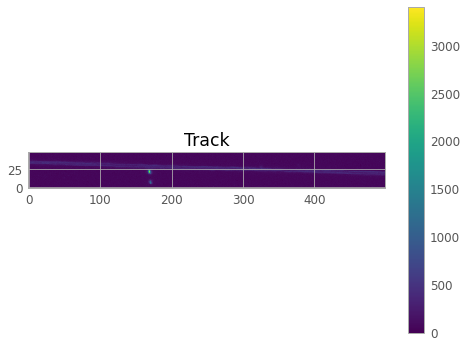

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_60597/253592785.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


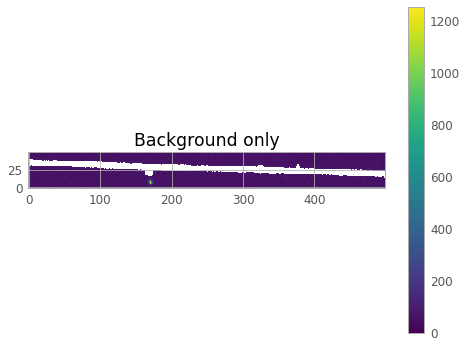

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_60597/253592785.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


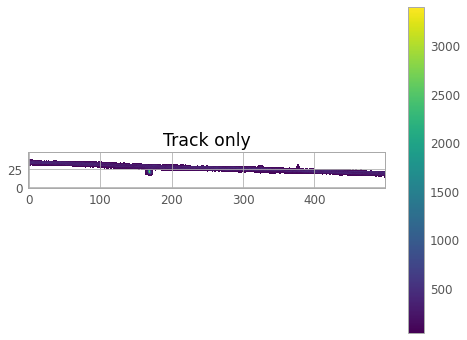

In [3]:
# small outcut of a track
track_data = image_clean[2780:2830,0:500]
avg = np.mean(track_data)
mask = make_source_mask(track_data, nsigma=4, npixels=1000, dilate_size=2)
track = np.ma.array(track_data, mask=np.logical_not(mask), fill_value=0)
mean, median, std = sigma_clipped_stats(track_data, sigma=4.0, mask=mask)
mask = make_source_mask(track_data, nsigma=4, npixels=1000, dilate_size=2)
masked_image = np.ma.masked_where(mask, track_data)

plt.figure()
plt.title('Track')
plt.imshow(track_data, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background only')
plt.imshow(masked_image, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Track only')
plt.imshow(track, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_60597/2953316225.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


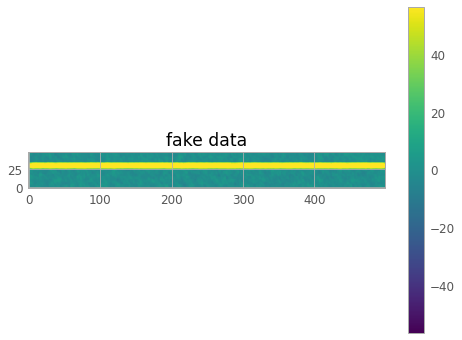

In [4]:
# Create fake data
initial_guess = (300, 0, 300, 500, 1, 1000)
track_data = trackModel(np.shape(track_data), 30, 0, 30, 500, 1, 1000) + np.random.normal(scale=std, size=np.shape(track_data))
track_data = convolve2d(track_data, PSF, 'same')

plt.figure()
plt.title('fake data')
plt.imshow(track_data, origin='lower', cmap='viridis', interpolation='none', vmin=-5*std, vmax=5*std)
plt.colorbar()
plt.show()


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_60597/3937935499.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


56.54960487468909


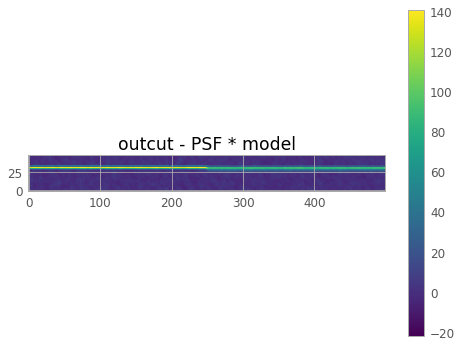

In [5]:
# Convolution of model and PSF to get what we would measure
track_model = trackModel(np.shape(track_data), 29, 0, 31, 500, 1, 567)
convolved_track = convolve2d(track_model, PSF, 'same')
#mean, median, std = sigma_clipped_stats(track_data, sigma=4.0, mask=mask)
print(reducedGoodnessModel(track_data, convolved_track, std))

plt.figure()
plt.title('outcut - PSF * model')
plt.imshow(track_data-convolved_track, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

In [21]:
# Model parameter fitting using Marginalization & uncertainty estimation
# source https://emcee.readthedocs.io/en/stable/tutorials/line/
from multiprocessing import Pool
#np.seterr(all="ignore")
#initial_guess = [295, 5, 305, 495, 1, 1000]
initial_guess = [25, 35, 1, 1050]
pos = initial_guess + 1e-1 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logProbability, args=(track_data, std, PSF, True), pool=pool)
    sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [21:29<00:00,  3.88it/s]


[66.12650838 71.22113996 93.66389424 87.38400857]


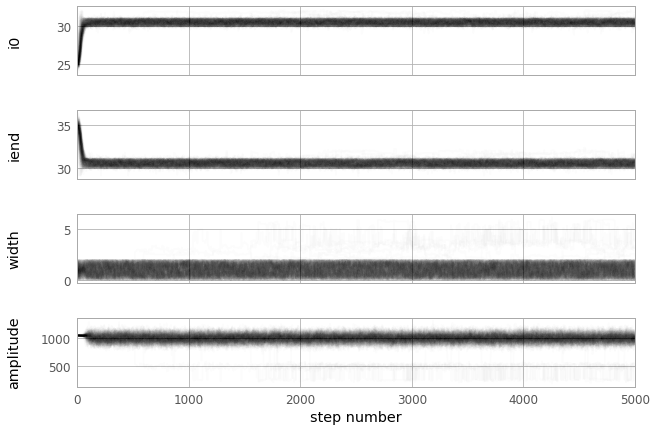

In [22]:
# looking at the steps
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["i0", "iend", "width", "amplitude"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.01)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

# autocorrection time
tau = sampler.get_autocorr_time()
print(tau)


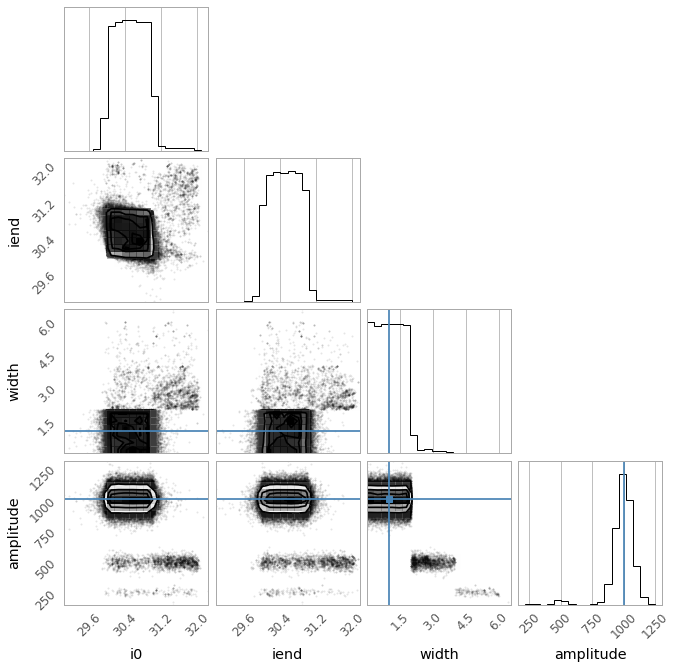

In [17]:
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
fig = corner.corner(flat_samples, labels=labels, truths=[300, 300, 1, 1000])


In [23]:
# percentiles
theta = [0, 0, 0, 0]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.1f}_{{-{1:.1f}}}^{{{2:.1f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    theta[i] = mcmc[1]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

chi^2:  0.1313447830313627


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_60597/3373790922.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ca = plt.colorbar()


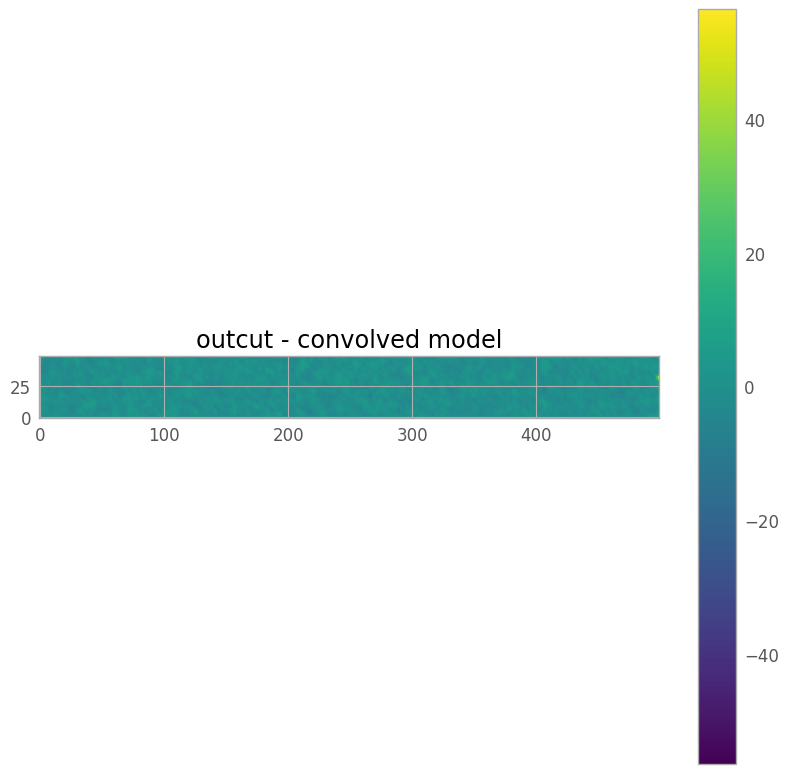

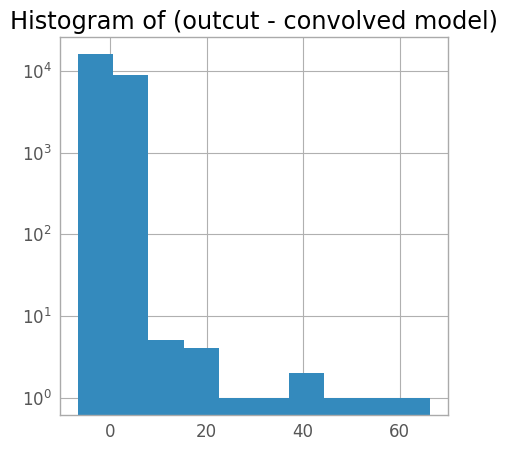

In [24]:
# best model
if len(theta) == 6:
    i0, j0, iend, jend, width, amplitude = theta
elif len(theta) == 4:
    i0, iend, width, amplitude = theta
else:
    raise ValueError('Not the correct number of parameters in theta')
best_model = simplerTrackModel(np.shape(track_data), i0, iend, width, amplitude)
chi2 = reducedGoodnessModel(track_data, convolve2d(best_model, PSF, 'same'), std)
print('chi^2: ', chi2)

plt.figure(figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
plt.title('outcut - convolved model')
#norm = ImageNormalize(stretch=SqrtStretch())
img = track_data - convolve2d(best_model, PSF, 'same')
plt.imshow(img, origin='lower', cmap='viridis', interpolation='none', vmin=-5*std, vmax=5*std)
ca = plt.colorbar()
plt.show()

#matplotlib.rcParams['figure.f#igsize'] = [10, 10]
plt.figure(figsize=(5, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Histogram of (outcut - convolved model)')
plt.hist(img.flatten(), bins=10)
plt.yscale('log')
plt.show()
